1D CNN FOR A BINARY CLASSIFICATION PROBLEM: Physical or Non physical matrix?

The problem is always the same, but I want try to solve it by exploiting a 1D CNN. The goal is to compare the performance of the MLP with the 1D CNN to solve this binary problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath

DATASET CREATION

I want to arrange data from the MATLAB code in order to have 2 channels. Consequently, I stack data in order to have a dataset of dimension (600,17,2). Each row represent a different Physical or NonPhysical matrix. For each channel, each matrix has 16 features, the last column is the label for the binary classification (0 or 1). In the first channel, the 16 features are the real part of each element in the matrix. In the second channel, features are the respectively imaginary part.

In [2]:
#import data generated in MATLAB
physical_real=np.loadtxt(r'/content/300_Physical_matrices_Dim=4_RealPart.txt')
Non_physical_real=np.loadtxt(r'/content/300_Non_Physical_matrices_Dim=4_RealPart.txt')
physical_imag=np.loadtxt(r'/content/300_Physical_matrices_Dim=4_ImagPart.txt')
Non_physical_imag=np.loadtxt(r'/content/300_Non_Physical_matrices_Dim=4_ImagPart.txt')

################ TO CREATE THE DATASET #############

#Classifier: 0-> Physical matrix, 1-> Non physical matrix
target_Physical=np.zeros((physical_real.shape[0],1),dtype=int)
target_NonPhysical=np.ones((physical_real.shape[0],1),dtype=int)

Physical_real=np.concatenate((physical_real,target_Physical), axis=1)
Physical_imag=np.concatenate((physical_imag,target_Physical), axis=1)
NonPhysical_real=np.concatenate((Non_physical_real,target_NonPhysical), axis=1)
NonPhysical_imag=np.concatenate((Non_physical_imag,target_NonPhysical), axis=1)
Physical_data=np.stack((Physical_real,Physical_imag),axis=2)
NonPhysical_data=np.stack((NonPhysical_real,NonPhysical_imag),axis=2)
#print("Physical data size:  ", Physical_data.shape, ", Non Physical data size: ", NonPhysical_data.shape)

dataset=np.concatenate((Physical_data, NonPhysical_data), axis=0)
print("Dataset dimension", dataset.shape)

features=dataset[:,:-1,:]
target=dataset[:,-1,1]
print("features size: ", features.shape, ", target size: ", target.shape)


Dataset dimension (600, 17, 2)
features size:  (600, 16, 2) , target size:  (600,)


Now, I can split the dataset in train and validation set, with a ratio of 2:1

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.33, shuffle=True)
print("X_train: ",X_train.shape,", X_val: " ,X_val.shape, ", Y_train: ", Y_train.shape, ", Y_val: ",Y_val.shape)

X_train:  (402, 16, 2) , X_val:  (198, 16, 2) , Y_train:  (402,) , Y_val:  (198,)


BUILDING THE CNN MODEL

In [4]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation,Conv1D, AveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [5]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25

First, I try to build a simple CNN with only one convolutional layer. I try to change both the number of neurons in the convolutional layer and the kernel size to see how this affect the model performances. For the moment I don't use pooling. I fix the stride to 1 and I don't use padding. I fixed also the number of neurons in the two layers of the MLP. I evaluete the performances with the validation accuracy and the ROC curve.

In [ ]:
inputList = Input(shape=(featureArrayLength))
neurons=[10,20,35,55,75]
kernel_size=[1,4,8,16]
models=[]

for n in neurons:
  for k in kernel_size:
    x = Conv1D(n, kernel_size=k, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
    x = Flatten()(x)
    x = Dense(25, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(15, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    output = Dense(1, activation='sigmoid')(x)
####
    model = Model(inputs=inputList, outputs=output)
    models=np.append(models,model)

In [ ]:
for m in models:
  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 10)            30        
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 25)                4025      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0     

In [ ]:
batch_size = 30
n_epochs = 250

histories=[]

for m in models:
  m.summary()
  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories=np.append(histories,history)
  del history, train_acc, val_acc

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 10)            30        
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 25)                4025      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0     

Since I have a lot of models, I decide to plot only the validation loss and accuracy for that models that reach a validation accuracy above 0.86. Before to do this, I verify that all the models reach the minimul loss both for training and the validation set (they converge to the minimum).

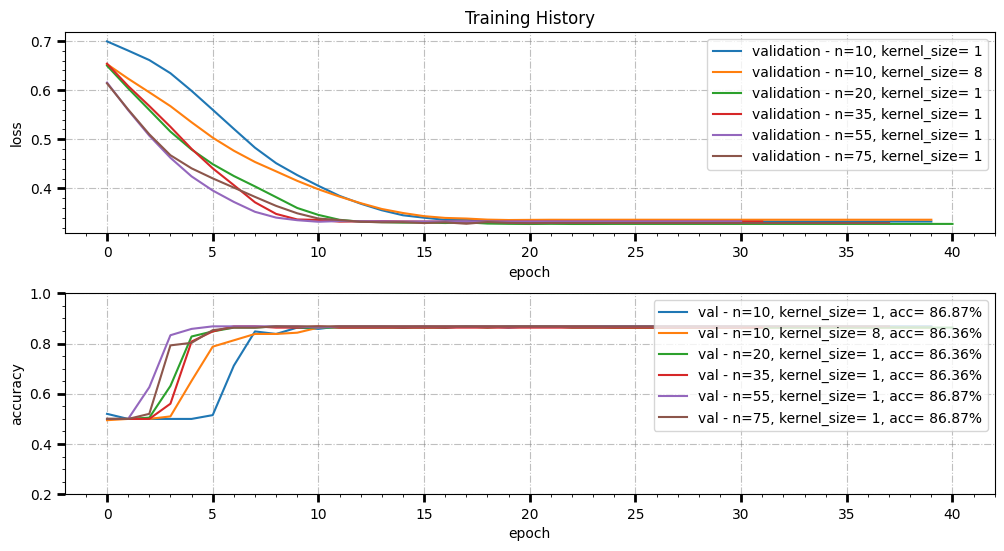

In [ ]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

j=0
for i,hist in enumerate(histories):
  if models[i].layers[1].output.shape[1]==16:
    j=0
  if hist.history['val_accuracy'][-1]>0.86:
    #ax0.plot(hist.history['loss'],label='training - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
    ax0.plot(hist.history['val_loss'], label='validation - n='+str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
  j=j+1
#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(histories):
  if models[i].layers[1].output.shape[1]==16:
    j=0
  if hist.history['val_accuracy'][-1]>0.86:
    #ax1.plot(hist.history['accuracy'],label='train - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j])+', acc= '+ str(np.round(hist.history['accuracy'][-1]*100.,2)))
    ax1.plot(hist.history['val_accuracy'], label='val - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j])+', acc= '+ str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')
  j=j+1
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

7/7 [==============================] - 0s 2ms/step


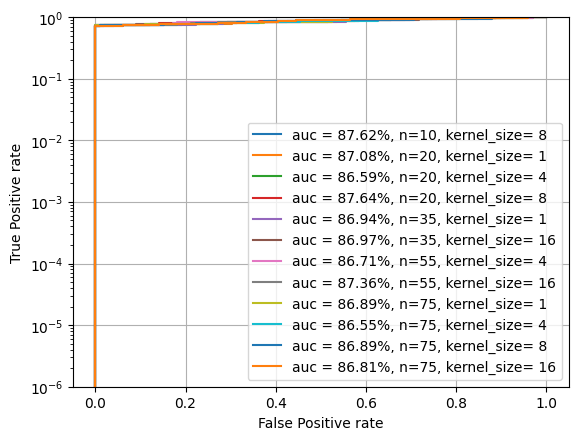

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

predict_val =[]
fpr=[]
tpr=[]
auc1=[]


for i,m in enumerate(models):
  predicted=m.predict(X_val)
  if i==0:
    predict_val=predicted
  else:
    predict_val=np.concatenate((predict_val,predicted),axis=1)



df = pd.DataFrame()
plt.figure()

j=0
for i in range(predict_val.shape[1]):
  if models[i].layers[1].output.shape[1]==16:
    j=0
  fpr_, tpr_, threshold = roc_curve(Y_val,predict_val[:,i])
  auc_= auc(fpr_, tpr_)
  if auc_>0.865:
    plt.plot(fpr_,tpr_,label='auc = '+ str(np.round(auc_*100.,2))+'%, n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
  j=j+1
plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()


We obtain the higher values of accuracies for different numbers of neurons but all with a kernel size = 1. In the ROC curve, in general the AUC parameter is better for kernel size different from 1. Since I am more interested in the accuracy, I try to fix the number of neurons to 75 (because it gives to me the higher accuracy and also the higher AUC parameter) and to change the kernel size in a range of smaller values (from 1 to 4). I try to use padding.

In [6]:
inputList = Input(shape=(featureArrayLength))

kernel_size=[1,2,3,4]
models2=[]

for k in kernel_size:
  x = Conv1D(75, kernel_size=k, data_format="channels_last", strides=1, padding="same", activation='relu')(inputList)
  x = Flatten()(x)
  x = Dense(25, activation='relu')(x)
  x = Dropout(dropoutRate)(x)
  x = Dense(15, activation='relu')(x)
  x = Dropout(dropoutRate)(x)
  output = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputList, outputs=output)
  models2=np.append(models2,model)

In [7]:
for m in models2:
  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 75)            225       
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 25)                30025     
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0     

In [8]:
batch_size = 30
n_epochs = 250

histories2=[]

for m in models2:
  m.summary()
  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories2=np.append(histories2,history)
  del history, train_acc, val_acc

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 75)            225       
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 25)                30025     
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0     

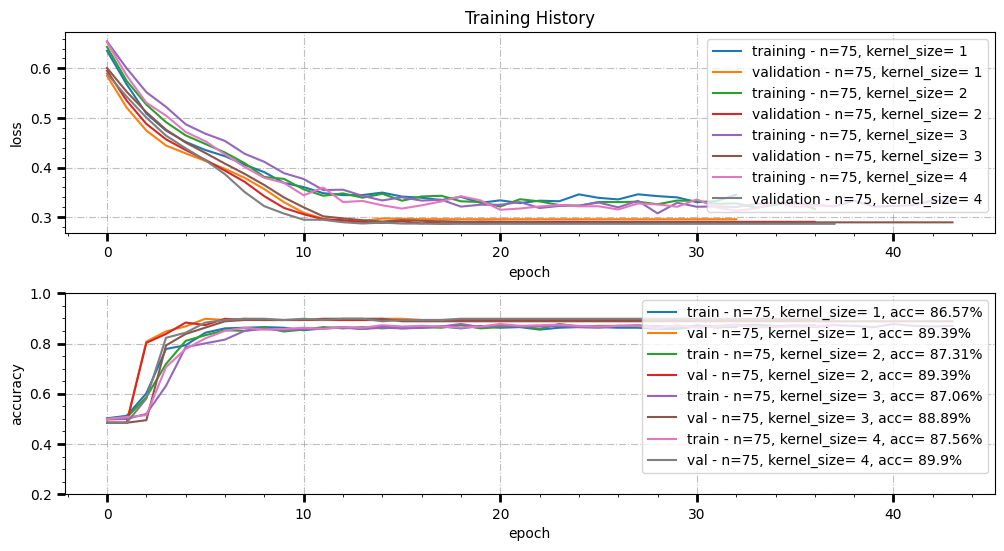

In [9]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.3)


for i,hist in enumerate(histories2):
  ax0.plot(hist.history['loss'],label='training - n=75, kernel_size= ' + str(kernel_size[i]))
  ax0.plot(hist.history['val_loss'], label='validation - n=75, kernel_size= ' + str(kernel_size[i]))

#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(histories2):
  ax1.plot(hist.history['accuracy'],label='train - n=75, kernel_size= ' + str(kernel_size[i])+', acc= '+ str(np.round(hist.history['accuracy'][-1]*100.,2))+'%')
  ax1.plot(hist.history['val_accuracy'], label='val - n=75, kernel_size= ' + str(kernel_size[i])+', acc= '+ str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')

ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

It seems that the performance are better than before. In particular I obtain the best validation accuracy of 89.9% with a kernel size of 4 and the padding tecnique (training accuracy= 87.56%). Now, I try to use also pooling to reduce the dimensionality of the model.

In [10]:
inputList = Input(shape=(featureArrayLength))

pooling_size=[1,2,5,9,12]
models_=[]

for p in pooling_size:

  x = Conv1D(75, kernel_size=4, data_format="channels_last", strides=1, padding="same", activation='relu')(inputList)
  x = AveragePooling1D(pool_size=p)(x)
  x = Flatten()(x)
  x = Dense(25, activation='relu')(x)
  x = Dropout(dropoutRate)(x)
  x = Dense(15, activation='relu')(x)
  x = Dropout(dropoutRate)(x)
  output = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputList, outputs=output)
  models_=np.append(models_,model)

for m in models_:

  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()




Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 75)            675       
                                                                 
 average_pooling1d (AverageP  (None, 16, 75)           0         
 ooling1D)                                                       
                                                                 
 flatten_4 (Flatten)         (None, 1200)              0         
                                                                 
 dense_12 (Dense)            (None, 25)                30025     
                                                                 
 dropout_8 (Dropout)         (None, 25)                0         
                                                           

In [11]:
batch_size = 30
n_epochs = 250

histories_=[]
for m in models_:

  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories_=np.append(histories_,history)
  del history,train_acc, val_acc

Epoch 1/250
14/14 - 2s - loss: 0.6175 - accuracy: 0.5075 - val_loss: 0.5710 - val_accuracy: 0.4848 - lr: 0.0010 - 2s/epoch - 137ms/step
Epoch 2/250
14/14 - 0s - loss: 0.5504 - accuracy: 0.5075 - val_loss: 0.5123 - val_accuracy: 0.4848 - lr: 0.0010 - 104ms/epoch - 7ms/step
Epoch 3/250
14/14 - 0s - loss: 0.5046 - accuracy: 0.6318 - val_loss: 0.4682 - val_accuracy: 0.8182 - lr: 0.0010 - 112ms/epoch - 8ms/step
Epoch 4/250
14/14 - 0s - loss: 0.4660 - accuracy: 0.7537 - val_loss: 0.4425 - val_accuracy: 0.8232 - lr: 0.0010 - 88ms/epoch - 6ms/step
Epoch 5/250
14/14 - 0s - loss: 0.4502 - accuracy: 0.8010 - val_loss: 0.4311 - val_accuracy: 0.8737 - lr: 0.0010 - 90ms/epoch - 6ms/step
Epoch 6/250
14/14 - 0s - loss: 0.4384 - accuracy: 0.8483 - val_loss: 0.4225 - val_accuracy: 0.8788 - lr: 0.0010 - 92ms/epoch - 7ms/step
Epoch 7/250
14/14 - 0s - loss: 0.4319 - accuracy: 0.8458 - val_loss: 0.4156 - val_accuracy: 0.8788 - lr: 0.0010 - 101ms/epoch - 7ms/step
Epoch 8/250
14/14 - 0s - loss: 0.4259 - accur

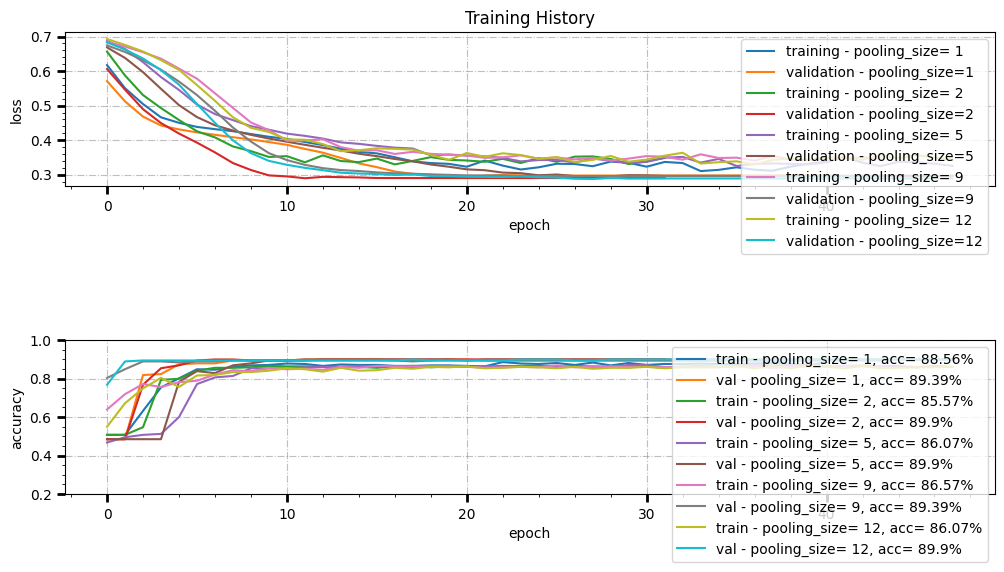

In [13]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=1, wspace=0.3)

for i,hist in enumerate(histories_):
  ax0.plot(hist.history['loss'],label='training - pooling_size= '+str(pooling_size[i]))
  ax0.plot(hist.history['val_loss'], label='validation - pooling_size='+str(pooling_size[i]))

#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(histories_):
  ax1.plot(hist.history['accuracy'],label='train - pooling_size= '+str(pooling_size[i])+', acc= '+ str(np.round(hist.history['accuracy'][-1]*100.,2))+'%')
  ax1.plot(hist.history['val_accuracy'], label='val - pooling_size= '+str(pooling_size[i])+', acc= '+ str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')

ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

With the use of the pooling tecnique the accuracy does not increase but remain the same of before. What change drastically is the number of trainable parameters in the model. We pass from 31,106 total parameters in the model with a pooling size of 1 to 2,981 for a pooling size of 12.

I decide to use I pooling_size of 5 and now I try to add a second convolutional layer. I try to change the number of neurons and the kernel size. I use padding.

In [14]:
inputList = Input(shape=(featureArrayLength))

neurons= [20,35,50,70]
kernel_size=[1,2,4,8,16]
models3=[]
for n in neurons:
  for k in kernel_size:
    x = Conv1D(75, kernel_size=4, data_format="channels_last", strides=1, padding="same", activation='relu')(inputList)
    x = AveragePooling1D(pool_size=5)(x)
    x = Conv1D(n, kernel_size=k, data_format="channels_last", strides=1, padding="same", activation='relu')(x)
    x = Flatten()(x)
    x = Dense(25, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(15, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputList, outputs=output)
    models3=np.append(models3,model)

for m in models3:
  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 16, 75)            675       
                                                                 
 average_pooling1d_5 (Averag  (None, 3, 75)            0         
 ePooling1D)                                                     
                                                                 
 conv1d_10 (Conv1D)          (None, 3, 20)             1520      
                                                                 
 flatten_9 (Flatten)         (None, 60)                0         
                                                                 
 dense_27 (Dense)            (None, 25)                1525      
                                                           

In [15]:
batch_size = 30
n_epochs = 250

histories3=[]

for m in models3:
  m.summary()
  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories3=np.append(histories3,history)
  del history, train_acc, val_acc

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 16, 75)            675       
                                                                 
 average_pooling1d_5 (Averag  (None, 3, 75)            0         
 ePooling1D)                                                     
                                                                 
 conv1d_10 (Conv1D)          (None, 3, 20)             1520      
                                                                 
 flatten_9 (Flatten)         (None, 60)                0         
                                                                 
 dense_27 (Dense)            (None, 25)                1525      
                                                           

I plot only the validation loss and accuracy to have a more clear plot. I plot only the performance of models that have a validation accuracy above 0.898

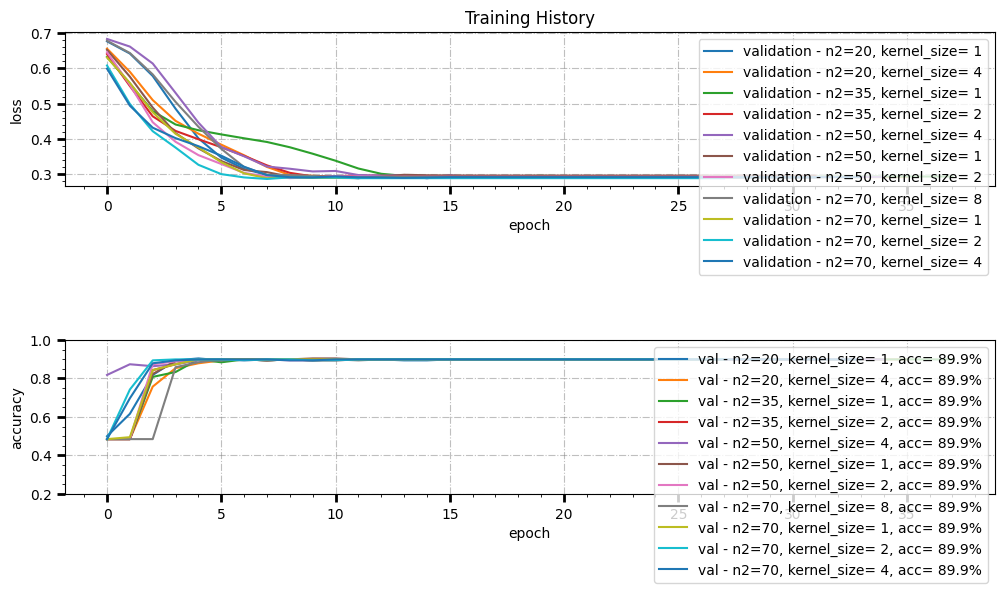

In [20]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=1, wspace=0.3)

j=0
for i,hist in enumerate(histories3):
  if j==4:
    j=0
  if hist.history['val_accuracy'][-1]>0.898:
    #ax0.plot(hist.history['loss'],label='training - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
    ax0.plot(hist.history['val_loss'], label='validation - n2='+str(models3[i].layers[3].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
  j=j+1
#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

j=0
for i,hist in enumerate(histories3):
  if j==4:
    j=0
  if hist.history['val_accuracy'][-1]>0.898:
    #ax1.plot(hist.history['accuracy'],label='train - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j])+', acc= '+ str(np.round(hist.history['accuracy'][-1]*100.,2)))
    ax1.plot(hist.history['val_accuracy'], label='val - n2='+ str(models3[i].layers[3].output.shape[2])+', kernel_size= ' + str(kernel_size[j])+', acc= '+ str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')
  j=j+1
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

7/7 [==============================] - 0s 2ms/step


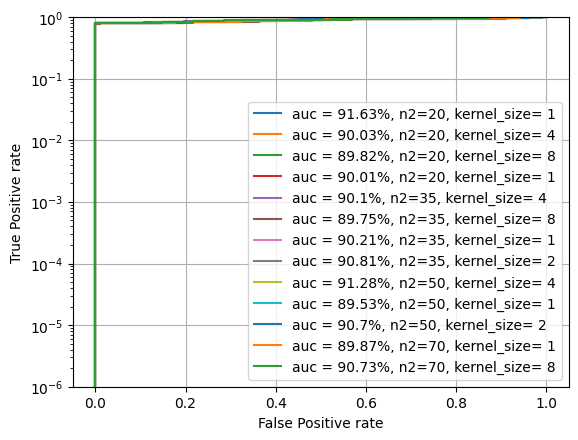

In [27]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

predict_val =[]
fpr=[]
tpr=[]
auc1=[]


for i,m in enumerate(models3):
  predicted=m.predict(X_val)
  if i==0:
    predict_val=predicted
  else:
    predict_val=np.concatenate((predict_val,predicted),axis=1)



df = pd.DataFrame()
plt.figure()

j=0
for i in range(predict_val.shape[1]):
  if j==4:
    j=0
  fpr_, tpr_, threshold = roc_curve(Y_val,predict_val[:,i])
  auc_= auc(fpr_, tpr_)
  if auc_>0.895:
    plt.plot(fpr_,tpr_,label='auc = '+ str(np.round(auc_*100.,2))+'%, n2='+ str(models3[i].layers[3].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
  j=j+1
plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()



After this analysis, I obtain that there are more models that reach the higher validation accuracy of 89.9%. At the same time there are models in which the AUC parameter exceed 91%. Since I obtain the maximum of the validation accuracy and an AUC parameter (above 91%) in a model with a number of neurons in the second convolutional layer of 50 and a kernel size of 4, I decide to fix these parameters for the following investigations.

Now I try to reduce the dimensionality of the model by adding pooling after the second convolutional layer.

In [32]:
inputList = Input(shape=(featureArrayLength))

x = Conv1D(75, kernel_size=4, data_format="channels_last", strides=1, padding="same", activation='relu')(inputList)
x = AveragePooling1D(pool_size=5)(x)
x = Conv1D(50, kernel_size=4, data_format="channels_last", strides=1, padding="same", activation='relu')(x)
x = AveragePooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(25, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(15, activation='relu')(x)
x = Dropout(dropoutRate)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputList, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_77 (Conv1D)          (None, 16, 75)            675       
                                                                 
 average_pooling1d_53 (Avera  (None, 3, 75)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_78 (Conv1D)          (None, 3, 50)             15050     
                                                                 
 average_pooling1d_54 (Avera  (None, 1, 50)            0         
 gePooling1D)                                                    
                                                                 
 flatten_41 (Flatten)        (None, 50)                0  

In [33]:
batch_size = 30
n_epochs = 250


# train
history = model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, val_acc = model.evaluate(X_val, Y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
print('#####################################')


Epoch 1/250
14/14 - 3s - loss: 0.6606 - accuracy: 0.5473 - val_loss: 0.6171 - val_accuracy: 0.4848 - lr: 0.0010 - 3s/epoch - 222ms/step
Epoch 2/250
14/14 - 0s - loss: 0.5830 - accuracy: 0.5522 - val_loss: 0.5142 - val_accuracy: 0.7929 - lr: 0.0010 - 102ms/epoch - 7ms/step
Epoch 3/250
14/14 - 0s - loss: 0.4878 - accuracy: 0.7811 - val_loss: 0.4319 - val_accuracy: 0.8939 - lr: 0.0010 - 99ms/epoch - 7ms/step
Epoch 4/250
14/14 - 0s - loss: 0.4383 - accuracy: 0.8433 - val_loss: 0.3844 - val_accuracy: 0.8939 - lr: 0.0010 - 112ms/epoch - 8ms/step
Epoch 5/250
14/14 - 0s - loss: 0.4032 - accuracy: 0.8607 - val_loss: 0.3502 - val_accuracy: 0.8990 - lr: 0.0010 - 101ms/epoch - 7ms/step
Epoch 6/250
14/14 - 0s - loss: 0.3735 - accuracy: 0.8582 - val_loss: 0.3188 - val_accuracy: 0.8990 - lr: 0.0010 - 109ms/epoch - 8ms/step
Epoch 7/250
14/14 - 0s - loss: 0.3487 - accuracy: 0.8607 - val_loss: 0.2994 - val_accuracy: 0.8939 - lr: 0.0010 - 100ms/epoch - 7ms/step
Epoch 8/250
14/14 - 0s - loss: 0.3515 - acc

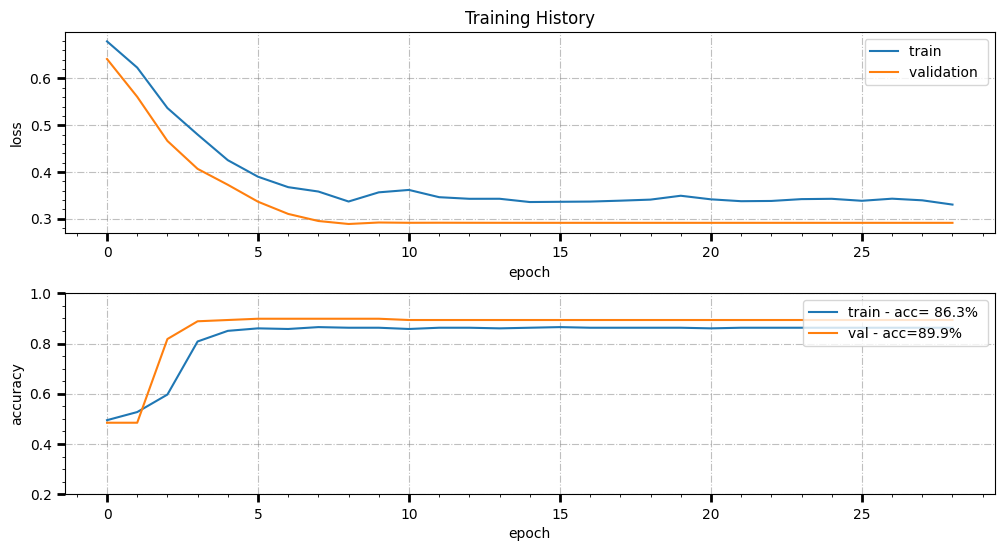

In [35]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

ax0.plot(hist.history['loss'],label= 'train ')
ax0.plot(hist.history['val_loss'], label='validation ')
#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')


ax1.plot(hist.history['accuracy'],label='train - acc= 86.3% ')
ax1.plot(hist.history['val_accuracy'], label='val - acc=89.9% ')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

Finally, I fixed all the parameter in the convolutional part of the model and I change only the number of neurons present in the MLP part of the model.

In [36]:
inputList = Input(shape=(featureArrayLength))

neurons1=[15,25,35,50]
neurons2=[1,10,15,20,25]
models5=[]

for n1 in neurons1:
  for n2 in neurons2:
    x = Conv1D(75, kernel_size=4, data_format="channels_last", strides=1, padding="same", activation='relu')(inputList)
    x = AveragePooling1D(pool_size=5)(x)
    x = Conv1D(50, kernel_size=4, data_format="channels_last", strides=1, padding="same", activation='relu')(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(n1, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(n2, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputList, outputs=output)
    models5=np.append(models5,model)

for m in models5:
  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_79 (Conv1D)          (None, 16, 75)            675       
                                                                 
 average_pooling1d_55 (Avera  (None, 3, 75)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_80 (Conv1D)          (None, 3, 50)             15050     
                                                                 
 average_pooling1d_56 (Avera  (None, 1, 50)            0         
 gePooling1D)                                                    
                                                                 
 flatten_42 (Flatten)        (None, 50)                0  

In [37]:
batch_size = 30
n_epochs = 250

histories5=[]

for m in models5:
  m.summary()
  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories5=np.append(histories5,history)
  del history, train_acc, val_acc

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_79 (Conv1D)          (None, 16, 75)            675       
                                                                 
 average_pooling1d_55 (Avera  (None, 3, 75)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_80 (Conv1D)          (None, 3, 50)             15050     
                                                                 
 average_pooling1d_56 (Avera  (None, 1, 50)            0         
 gePooling1D)                                                    
                                                                 
 flatten_42 (Flatten)        (None, 50)                0  

As in the previous cases, I plot only the loss function and validation accuracy for models with a validation accuracy exceeding 0.895.

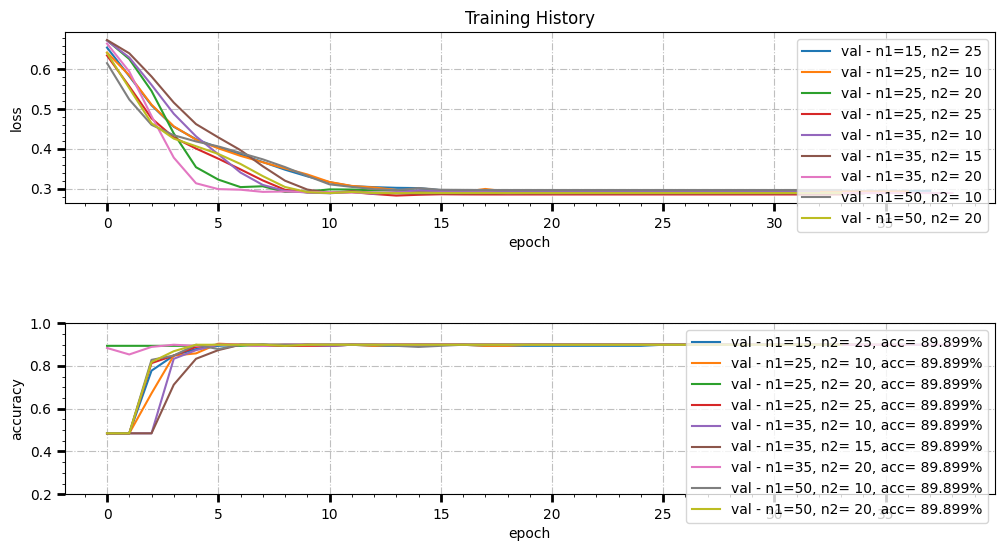

In [41]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.7, wspace=0.3)


for i,hist in enumerate(histories5):
  if hist.history['val_accuracy'][-1]>0.894:
    ax0.plot(hist.history['val_loss'],label= 'val - n1='+str(models5[i].layers[6].output.shape[1])+', n2= ' + str(models5[i].layers[8].output.shape[1]))
#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(histories5):
  if hist.history['val_accuracy'][-1]>0.894:
    ax1.plot(hist.history['val_accuracy'],label= 'val - n1='+str(models5[i].layers[6].output.shape[1])+', n2= ' + str(models5[i].layers[8].output.shape[1])+', acc= '+ str(np.round(hist.history['val_accuracy'][-1]*100.,3))+'%')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

7/7 [==============================] - 0s 2ms/step


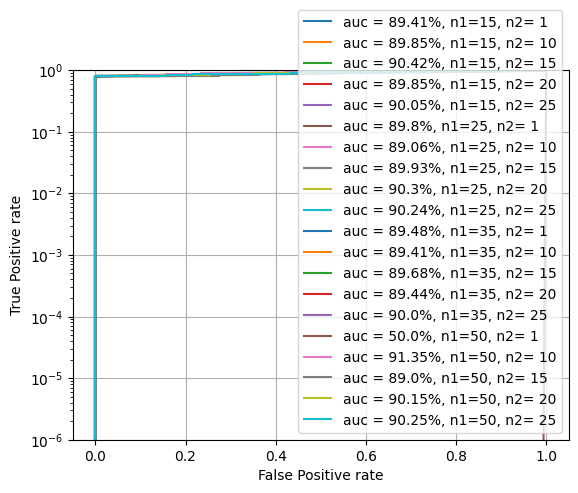

In [43]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

predict_val =[]
fpr=[]
tpr=[]
auc1=[]


for i,m in enumerate(models5):
  predicted=m.predict(X_val)
  if i==0:
    predict_val=predicted
  else:
    predict_val=np.concatenate((predict_val,predicted),axis=1)



df = pd.DataFrame()
plt.figure()


for i in range(predict_val.shape[1]):
  fpr_, tpr_, threshold = roc_curve(Y_val,predict_val[:,i])
  auc_= auc(fpr_, tpr_)
  plt.plot(fpr_,tpr_,label='auc = '+ str(np.round(auc_*100.,2))+'%, n1='+str(models5[i].layers[6].output.shape[1])+', n2= ' + str(models5[i].layers[8].output.shape[1]))

plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

Finally, I found that the model that gives me the best performance is that with n1=50 and n2=10. It has a validation accuracy of 89.9% (training accuracy= 86.3%) with a AUC parameter of 91.35%.

I built two different neural network to solve a binary classification problem: an MLP and a 1D CNN. In both the cases I reach good results since they exceed the 88% of validation accuracy and 89% of AUC parameter. In general, I reach slightly better results with the CNN since I have a validation accuracy of 89.9% and an AUC parameter of 91.35%.

I can conclude that both the model are good to solve my problem. The MLP is more simple and fast beacuse the total number of trainable parameters in the model is lower than CNN (about 3,000 parameters vs 20,000).